In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# setting the directory for dataset
train_dir = "archive/train"
val_dir = "archive/val"
test_dir = "archive/test"

In [4]:
# getting classnames
class_names = []
for dir_name in os.listdir(train_dir):
    class_names.append(dir_name)

In [6]:
# setting up filenames list
covid_img_paths = []
normal_img_paths = []
pneumonia_img_paths = []
tuberculosis_img_paths = []
def get_filenames(dir):
    """
    Gets filenames under the given directory
    """
    filenames = []
    for dir_name in os.listdir(dir):
        for file_name in os.listdir(dir + "/" + dir_name):
            filenames.append(dir + "/" + dir_name + "/" + file_name)
    return filenames
train_images = get_filenames(train_dir)
val_images = get_filenames(val_dir)
test_images = get_filenames(test_dir)


['archive/train/COVID19/COVID19(0).jpg',
 'archive/train/COVID19/COVID19(1).jpg',
 'archive/train/COVID19/COVID19(10).jpg',
 'archive/train/COVID19/COVID19(100).jpg',
 'archive/train/COVID19/COVID19(101).jpg']

In [7]:
device = 'cpu'
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1) 

C:\Users\Vedant\anaconda3\lib\site-packages\keras\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [8]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

In [9]:
def preprocess_images(path, shuffle=False):
    """
    Preprocess all the images in the given directory
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=path, batch_size=32, image_size=(224, 224), label_mode="categorical", seed=42, shuffle=shuffle
    )
    return dataset

('archive/train', 'archive/val', 'archive/test')

In [10]:
val_dataset = preprocess_images(val_dir, shuffle=True)

Found 38 files belonging to 4 classes.


In [11]:
test_dataset = preprocess_images(test_dir, shuffle=False) # shuffle-False for evaluation

Found 771 files belonging to 4 classes.


In [13]:
train_dataset = preprocess_images(train_dir, shuffle=True)

Found 6326 files belonging to 4 classes.


In [16]:
tf.random.set_seed(42)

# creating a neural network with dense layers
model_1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1/255.),
    tf.keras.layers.Flatten(), # needs to be flattened
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax")
], name="model_1_Dense")

# compiling the model
model_1.compile(
    loss="categorical_crossentropy",
    optimizer="Adam",
    metrics=["accuracy"]
)

# fitting the model
model_1_history = model_1.fit(train_dataset, epochs=2, validation_data=val_dataset)

Epoch 1/2
198/198 [==============================] - 17s 83ms/step - loss: 1.6001 - accuracy: 0.6900 - val_loss: 1.0793 - val_accuracy: 0.5263
Epoch 2/2
198/198 [==============================] - 17s 82ms/step - loss: 0.4532 - accuracy: 0.8242 - val_loss: 1.0113 - val_accuracy: 0.5789


In [17]:
%%time
# making predictions
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs[:5]

25/25 [==============================] - 1s 43ms/step
CPU times: total: 7.27 s
Wall time: 1.42 s


array([[0.05417855, 0.00271397, 0.84147394, 0.10163354],
       [0.21296787, 0.00346218, 0.12768805, 0.6558818 ],
       [0.20805137, 0.07775489, 0.45797175, 0.25622198],
       [0.21468003, 0.128197  , 0.4132954 , 0.24382754],
       [0.17712799, 0.00113509, 0.07301896, 0.7487179 ]], dtype=float32)

In [18]:
def custom_prediction(model, img_path, rescale=False, org_label=False):
    """
    Returns a plotted image with predicted class and its probability
    """

    # first we need to preprocess the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, size=[224,224])
    if rescale:
        image = image / 255.
    # rescaling is not needed for EfficientNetV2B0 since it has a rescaling layer

    # making predictions
    pred_probs = model.predict(tf.expand_dims(image, axis=0)) # needs to be expanded due to batched train data
    preds = pred_probs.argmax(axis=1)

    color = "black"
    # if label is specified
    if org_label:
        if org_label == class_names[preds[0]]:
            color="green"
        else:
            color="red"

    # plotting the prediction with image
    plt.figure(figsize=(10,7))
    plt.imshow(plt.imread(img_path))
    plt.title(f"Prediction: {class_names[preds[0]].upper()}\nPrediction Probability: {np.max(pred_probs)*100:.2f}%", color=color)

    # if label is specified
    if org_label:
        plt.suptitle(f"Original: {org_label.upper()}", color="green")

    plt.xticks([])
    plt.yticks([]);

1/1 [==============================] - 0s 31ms/step


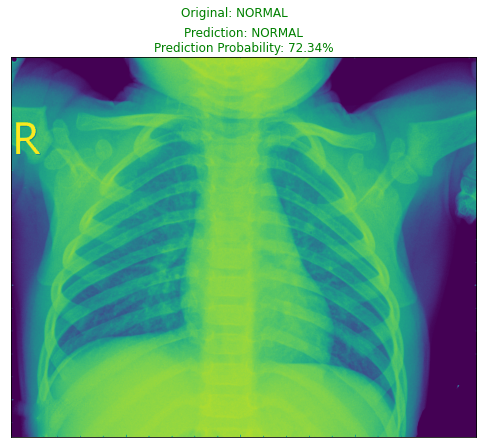

In [20]:
custom_prediction(model=model_1, img_path="archive/val/NORMAL/NORMAL2-IM-1430-0001.jpeg", org_label="NORMAL")